# Plant Recognition System — Training & Quantization
EfficientNetB0 model training pipeline with data generators, 
fine-tuning, evaluation and TFLite quantization.


In [23]:
# Core libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import time
import os
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc
)


## Configuration


In [24]:
BASE_DIR = 'data'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed')

IMG_SIZE = (224, 224)
INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-4

MODEL_SAVE_PATH = 'models/best_model.h5'
TFLITE_MODEL_PATH = 'models/model_quant.tflite'

os.makedirs('models', exist_ok=True)

with open(os.path.join(PROCESSED_DIR, 'class_indices.json'), 'r') as f:
    class_indices = json.load(f)

class_names = list(class_indices.keys())
NUM_CLASSES = len(class_names)

print(f"Classes: {NUM_CLASSES} → {class_names}")


Classes: 9 → ['Bacteria', 'Early_blight', 'Fungi', 'Healthy', 'Late_blight', 'Nematode', 'Pest', 'Phytopthora', 'Virus']


## Data Generators


In [25]:
def create_generators():
    train_datagen = ImageDataGenerator(
        rotation_range=8,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.02,
        zoom_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.95, 1.05],
        fill_mode='reflect',
        preprocessing_function=preprocess_input
    )
    
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    train_gen = train_datagen.flow_from_directory(
        os.path.join(PROCESSED_DIR, 'train'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_gen = val_datagen.flow_from_directory(
        os.path.join(PROCESSED_DIR, 'val'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_gen = test_datagen.flow_from_directory(
        os.path.join(PROCESSED_DIR, 'test'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_gen, val_gen, test_gen

train_gen, val_gen, test_gen = create_generators()


Found 3658 images belonging to 9 classes.
Found 785 images belonging to 9 classes.
Found 785 images belonging to 9 classes.


## Model Definition


In [26]:
def create_model():
    base_model = EfficientNetB0(
        include_top=False, weights='imagenet',
        input_shape=INPUT_SHAPE, pooling='avg'
    )
    base_model.trainable = True
    for layer in base_model.layers[:150]:
        layer.trainable = False

    inputs = tf.keras.Input(shape=INPUT_SHAPE)
    x = base_model(inputs, training=True)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    return models.Model(inputs, outputs)


## Training / Load Existing Model


In [27]:
model_exists = os.path.exists(MODEL_SAVE_PATH)

if model_exists:
    model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    print("Loaded existing model.")
else:
    model = create_model()
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Loaded existing model.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,846 (16.71 MB)

 Trainable params: 3,618,465 (13.80 MB)

 Non-trainable params: 762,379 (2.91 MB)

 Optimizer params: 2 (12.00 B)

## Fit Model


In [28]:
if not model_exists:
    callbacks = [
        ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, mode='max'),
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]

    steps_train = int(np.ceil(train_gen.samples / BATCH_SIZE))
    steps_val = int(np.ceil(val_gen.samples / BATCH_SIZE))

    start = time.time()
    history = model.fit(
        train_gen, steps_per_epoch=steps_train,
        validation_data=val_gen, validation_steps=steps_val,
        epochs=EPOCHS, callbacks=callbacks, verbose=1
    )
    training_time = time.time() - start

    # Training curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()

    plt.savefig('models/training_history.png')
    plt.show()


## Evaluation


C:\Users\statv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step 

Classification Report:
              precision    recall  f1-score   support

    Bacteria       0.96      0.95      0.96        86
Early_blight       1.00      1.00      1.00       150
       Fungi       0.86      0.53      0.65       112
     Healthy       0.53      0.92      0.68        53
 Late_blight       0.99      0.99      0.99       150
    Nematode       0.45      1.00      0.62        10
        Pest       0.61      0.73      0.66        92
 Phytopthora       0.90      0.71      0.80        52
       Virus       0.85      0.71      0.78        80

    accuracy                           0.84       785
   macro avg       0.80      0.84      0.79       785
weighted avg       0.87      0.84      0.84       785



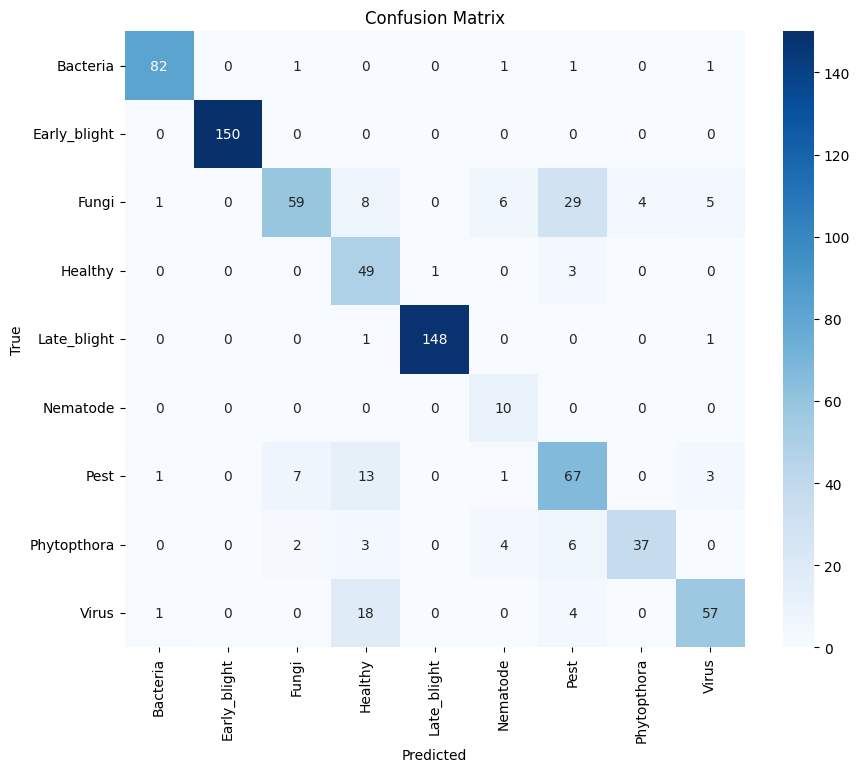


Class: Bacteria
  True Positives (TP): 82
  False Positives (Type I error): 3
  False Negatives (Type II error): 4
  True Negatives: 696

Class: Early_blight
  True Positives (TP): 150
  False Positives (Type I error): 0
  False Negatives (Type II error): 0
  True Negatives: 635

Class: Fungi
  True Positives (TP): 59
  False Positives (Type I error): 10
  False Negatives (Type II error): 53
  True Negatives: 663

Class: Healthy
  True Positives (TP): 49
  False Positives (Type I error): 43
  False Negatives (Type II error): 4
  True Negatives: 689

Class: Late_blight
  True Positives (TP): 148
  False Positives (Type I error): 1
  False Negatives (Type II error): 2
  True Negatives: 634

Class: Nematode
  True Positives (TP): 10
  False Positives (Type I error): 12
  False Negatives (Type II error): 0
  True Negatives: 763

Class: Pest
  True Positives (TP): 67
  False Positives (Type I error): 43
  False Negatives (Type II error): 25
  True Negatives: 650

Class: Phytopthora
  True 

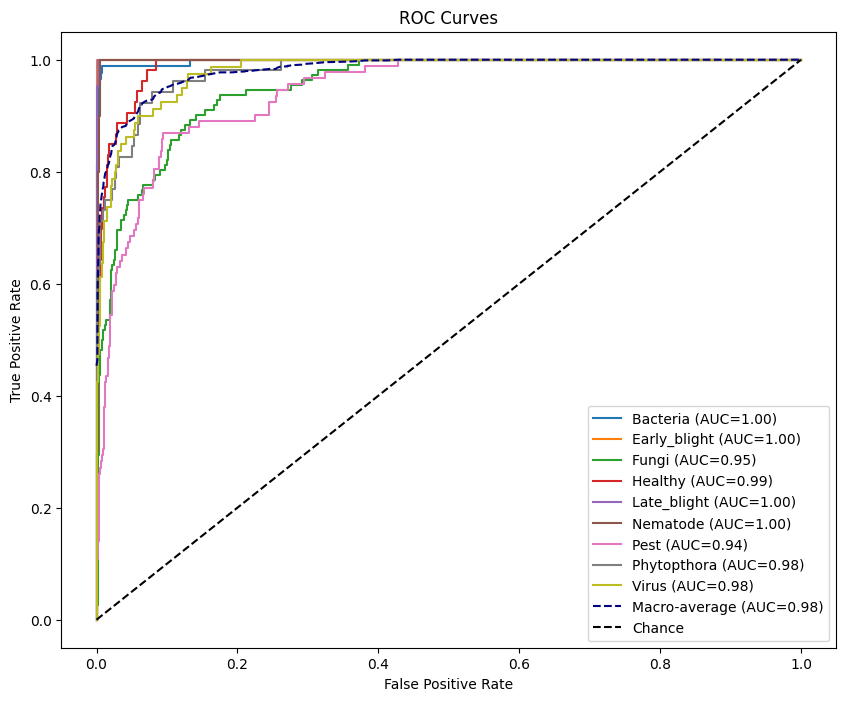

In [ ]:
## Detailed Evaluation

# Predictions
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('models/confusion_matrix.png')
plt.show()

# Type I & II errors (per class)
FP = cm.sum(axis=0) - np.diag(cm)   
FN = cm.sum(axis=1) - np.diag(cm)  
TP = np.diag(cm)                    
TN = cm.sum() - (FP + FN + TP)     

for i, cls in enumerate(class_names):
    print(f"\nClass: {cls}")
    print(f"  True Positives (TP): {TP[i]}")
    print(f"  False Positives (Type I error): {FP[i]}")
    print(f"  False Negatives (Type II error): {FN[i]}")
    print(f"  True Negatives: {TN[i]}")

# ROC & AUC (One-vs-Rest, macro average)
fpr, tpr, roc_auc = {}, {}, {}
plt.figure(figsize=(10,8))

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC={roc_auc[i]:.2f})")

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= NUM_CLASSES
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.plot(all_fpr, mean_tpr, color="navy", linestyle="--",
         label=f"Macro-average (AUC={roc_auc['macro']:.2f})")
plt.plot([0,1], [0,1], "k--", label="Chance")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig('models/roc_curves.png')
plt.show()


## Quantization to TFLite


In [30]:
if not os.path.exists(TFLITE_MODEL_PATH):
    def convert_to_tflite(model_path, tflite_path):
        model = tf.keras.models.load_model(model_path)
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

        def representative_dataset():
            for _ in range(100):
                batch = next(train_gen)
                yield [batch[0].astype(np.float32)]

        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8

        tflite_model = converter.convert()
        with open(tflite_path, 'wb') as f:
            f.write(tflite_model)
        return tflite_path

    tflite_model_path = convert_to_tflite(MODEL_SAVE_PATH, TFLITE_MODEL_PATH)
    print(f"TFLite model saved: {tflite_model_path}")


## Model Size & Report


In [31]:
def get_model_size(path):
    return os.path.getsize(path) / (1024*1024)

original_size = get_model_size(MODEL_SAVE_PATH)
quantized_size = get_model_size(TFLITE_MODEL_PATH)

print(f"Original: {original_size:.2f} MB | Quantized: {quantized_size:.2f} MB | Compression: {original_size/quantized_size:.1f}x")

def save_model_report():
    report = {
        "test_accuracy": float(test_acc),
        "model_size_mb": float(quantized_size),
        "classes": class_names,
        "input_shape": list(IMG_SIZE),
        "quantization": "INT8"
    }
    if 'training_time' in locals():
        report["training_time_min"] = float(training_time/60)
    with open('models/model_report.json', 'w') as f:
        json.dump(report, f, indent=2)
    return report

print(json.dumps(save_model_report(), indent=2))


Original: 44.85 MB | Quantized: 5.00 MB | Compression: 9.0x
{
  "test_accuracy": 0.8394904732704163,
  "model_size_mb": 5.002540588378906,
  "classes": [
    "Bacteria",
    "Early_blight",
    "Fungi",
    "Healthy",
    "Late_blight",
    "Nematode",
    "Pest",
    "Phytopthora",
    "Virus"
  ],
  "input_shape": [
    224,
    224
  ],
  "quantization": "INT8"
}
